In [1]:
import pandas as pd
%pylab inline
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [2]:
df_total = pd.read_csv("./data/terrain.csv")

In [3]:
df_total.head()

,bumpiness,grade,target
0,0.639427,0.099355,0.0
1,0.025011,0.685680,0.0
2,0.275029,0.544466,0.0
3,0.223211,0.977843,1.0
4,0.736471,0.358674,1.0


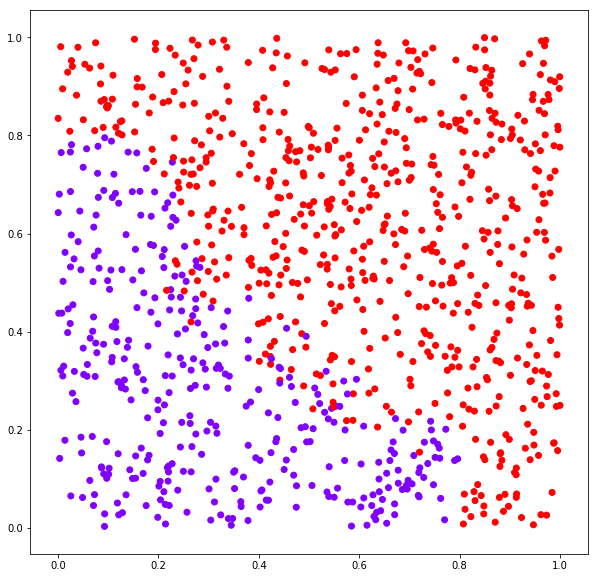

In [3]:
X = df_total[["bumpiness","grade"]].values
y = df_total["target"]
plt.figure(figsize=(10,10))
plt.scatter(X[:,0],X[:,1],c=y,cmap="rainbow")
plt.show()

In [4]:
from scipy import stats
import numpy as np

def entropy(attribute_data):
    _, val_freqs = np.unique(attribute_data, return_counts=True)
    val_probs = val_freqs / float(len(attribute_data))
    return -val_probs.dot(np.log(val_probs))

In [5]:
def cut_df(df,feature,percentile):
    return (df[feature].sort_values().iloc[:int(len(df)*percentile/100)].index,
            df[feature].sort_values().iloc[int(len(df)*percentile/100):].index)

def entropy_gain(df,feature,percentile):
    left,right = cut_df(df,feature,percentile)
    return entropy(df["target"]) \
         - entropy(df["target"].loc[left])*percentile/100 \
         - entropy(df["target"].loc[right])*(100-percentile)/100

In [6]:
entropy(df_total["target"])

0.64928400234260053

0.139251620146


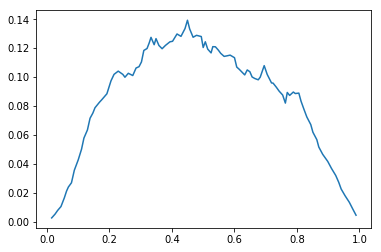

In [7]:
feature = "grade"
gains = [entropy_gain(df_total,feature,i) for i in range(1,100)]
values = [df_total[feature].sort_values().iloc[int(len(df_total)*i/100)] for i in range(1,100)]
plt.plot(values,gains)
print(max(gains))

0.1195874241


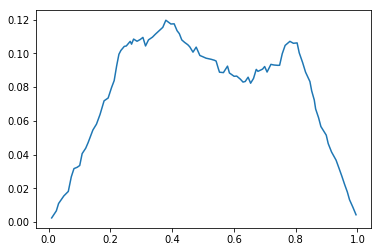

In [8]:
feature = "bumpiness"
gains = [entropy_gain(df_total,feature,i) for i in range(1,100)]
values = [df_total[feature].sort_values().iloc[int(len(df_total)*i/100)] for i in range(1,100)]
plt.plot(values,gains)
print(max(gains))

In [10]:
# So we cut by grade in 0.5

In [9]:
df_left = df_total[df_total["grade"]<=0.45]

0.0437580801761


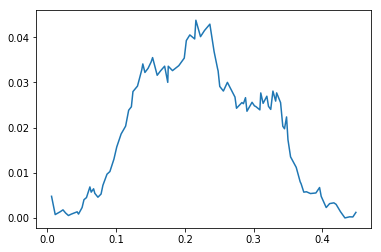

In [10]:
feature = "grade"
gains = [entropy_gain(df_left,feature,i) for i in range(1,100)]
values = [df_left[feature].sort_values().iloc[int(len(df_left)*i/100)] for i in range(1,100)]
plt.plot(values,gains)
print(max(gains))

0.266848859303


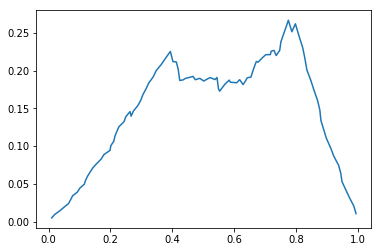

In [11]:
feature = "bumpiness"
gains = [entropy_gain(df_left,feature,i) for i in range(1,100)]
values = [df_left[feature].sort_values().iloc[int(len(df_left)*i/100)] for i in range(1,100)]
plt.plot(values,gains)
print(max(gains))

In [ ]:
# So we would do the cut in 0.78 for bumpiness

# sklearn Implementation

In [14]:
# Import the libs
from sklearn.tree import DecisionTreeClassifier

In [68]:
# Create the estimator and train it
clf=DecisionTreeClassifier(max_depth=4)
clf.fit(df_total[["bumpiness","grade"]],df_total["target"])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [14]:
from sklearn import tree

In [ ]:
!conda install graphviz

In [27]:
!pip install pydotplus

In [9]:
# Get an image from the estimator
from IPython.display import Image  
import pydotplus
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=["bumpiness", "grade"], 
                         class_names=["Slow","Fast"], 
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())  

ModuleNotFoundError: No module named 'pydotplus'

In [29]:
# Show the image

In [37]:
X = df_total[["bumpiness","grade"]].values
y = df_total["target"]

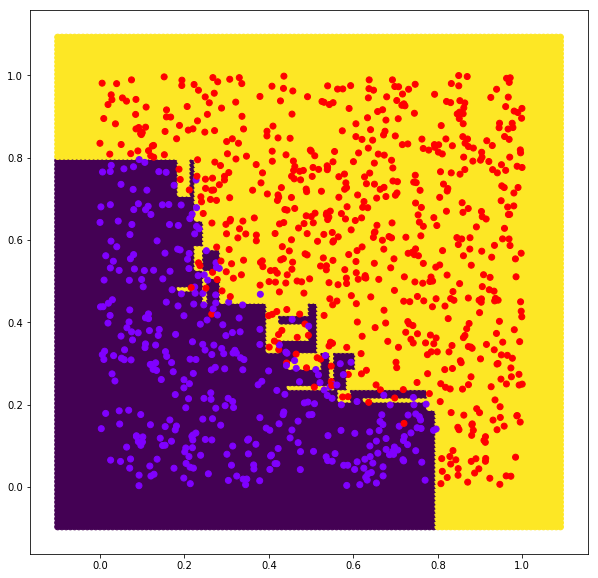

In [31]:
h = .01
x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + .1
y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10,10))
plt.scatter(xx, yy,c=Z)
plt.scatter(X[:,0],X[:,1],c=y,cmap="rainbow")
plt.show()

In [ ]:
# Train test split

In [33]:
# cross val score
from sklearn.model_selection import cross_val_score
cross_val_score(clf,X,y,cv=10)

array([ 0.93069307,  0.91089109,  0.95049505,  0.93      ,  0.96      ,
        0.93      ,  0.94      ,  0.91919192,  0.90909091,  0.92929293])

In [34]:
np.mean(cross_val_score(clf,X,y,cv=10))

0.93098549854985502

In [60]:
# Get the good params
from sklearn.model_selection import GridSearchCV
clf_good=GridSearchCV(DecisionTreeClassifier(),param_grid={"max_depth":range(1,100)},scoring="accuracy",cv=10)
clf_good.fit(X,y)

GridSearchCV(cv=10, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': range(1, 100)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='accuracy',
       verbose=0)

In [61]:
clf_good.best_params_

{'max_depth': 4}

In [63]:
nclf=tree.DecisionTreeClassifier(**clf_good.best_params_)
nclf

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [65]:
nclf.fit(X,y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

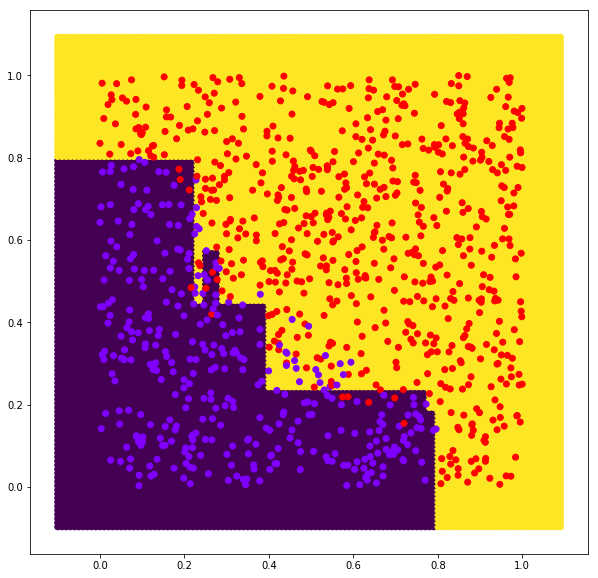

In [66]:
h = .01
x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + .1
y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
Z = nclf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10,10))
plt.scatter(xx, yy,c=Z)
plt.scatter(X[:,0],X[:,1],c=y,cmap="rainbow")
plt.show()

## Notion of Predict Probability

In [72]:
nclf.predict_proba(X)

array([[ 0.94680851,  0.05319149],
       [ 0.94117647,  0.05882353],
       [ 0.66666667,  0.33333333],
       ..., 
       [ 0.        ,  1.        ],
       [ 0.        ,  1.        ],
       [ 0.        ,  1.        ]])

## ROC Curve

In [ ]:
# http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
# https://datamize.wordpress.com/2015/01/24/how-to-plot-a-roc-curve-in-scikit-learn/
# http://gim.unmc.edu/dxtests/roc3.htm

In [73]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,random_state=42)

In [82]:
from sklearn.metrics import roc_curve,auc
false_positive_rate,true_positive_rate,threshold=roc_curve(y_test,nclf.predict_proba(X_test)[:,1])
roc_auc=auc(false_positive_rate,true_positive_rate)

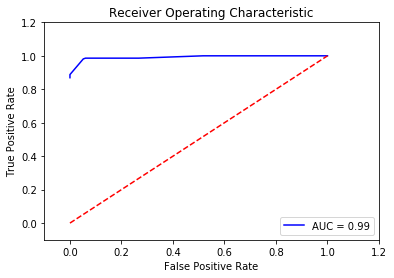

In [84]:
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [85]:
from sklearn.linear_model import LogisticRegression

In [86]:
bclf=LogisticRegression()
bclf.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [87]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, bclf.predict_proba(X_test)[:,1])
roc_auc = auc(false_positive_rate, true_positive_rate)

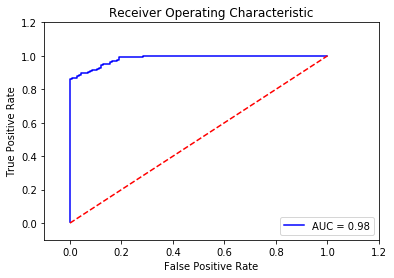

In [88]:
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Precision Recall Curve

In [ ]:
# http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html

In [ ]:
# https://www.coursera.org/learn/ml-classification/lecture/rENu8/precision-recall-curve

In [91]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test,nclf.predict_proba(X_test)[:,1])

In [93]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, nclf.predict_proba(X_test)[:,1])

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.99


Text(0.5,1,'2-class Precision-Recall curve: AP=0.99')

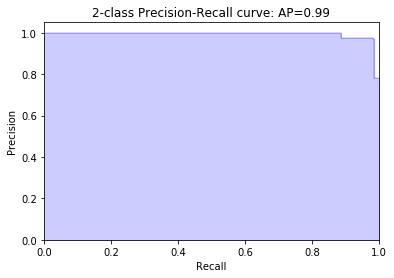

In [94]:
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

Average precision-recall score: 0.99


Text(0.5,1,'2-class Precision-Recall curve: AP=0.99')

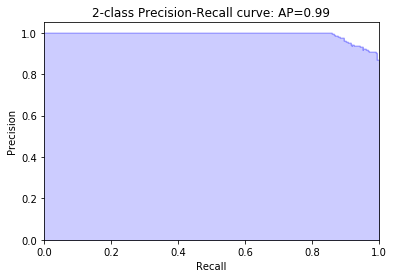

In [95]:
from sklearn.metrics import precision_recall_curve

y_score = bclf.predict_proba(X_test)[:,1]
precision, recall, _ = precision_recall_curve(y_test, y_score)
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))